# Deep learning enables accurate clustering and batch effect removal in single-cell RNA-seq analysis

Xiangjie Li<sup>1,2</sup>, Yafei Lyu<sup>1</sup>, Jihwan Park<sup>3</sup>, Jingxiao Zhang<sup>2</sup>, Dwight Stambolian<sup>4</sup>, Katalin Susztak<sup>3</sup>, Gang Hu<sup>1,5*</sup>, Mingyao Li<sup>1*</sup>

1) Department  of  Biostatistics,  Epidemiology  and  Informatics,  University  of  Pennsylvania Perelman School of Medicine, Philadelphia, PA 19104, USA.    
2) Center for Applied Statistics, School of Statistics, Renmin University, Beijing, China.  
3) Departments  of  Medicine  and  Genetics,  University  of  Pennsylvania  Perelman  School  of Medicine, Philadelphia, PA 19104, USA.    
4) Department  of  Ophthalmology,  University  of  Pennsylvania  Perelman  School  of  Medicine, Philadelphia,PA 19104, USA.      
5) Department of Information Theory and Data Science, School of Mathematical Sciences and LPMC, Nankai University, Tianjin 300071, China.  

\* Correspondence to Gang Hu (huggs@nankai.edu.cn) & Mingyao Li (mingyao@pennmedicine.upenn.edu)

# Introduction to ScRNA-Seq analysis
* Bulk RNA-Seq averages all expression values, removing the possibility of interpreting the contribution of individual cells
* __Single cell RNA-Seq (scRNA-Seq)__ allows researchers to analyze the transcriptome of individual cells to gain valuable biological insight
* Common RNA-Seq analysis involves grouping cells that have similar transcriptomes together, known as __clustering__
![t_sne_clustering](./t_sne_scRNA-Seq_clustering_60_shrunk.png)
Adapted from: http://data-science-sequencing.github.io/Win2018/lectures/lecture19/

# Clustering algorithms do not scale well

* ScRNA-seq can potentially process tens of thousands of cells


* Human genome contains an estimated 22,000 genes w/ multiple transcripts/gene


* t-SNE, a commonly used clustering algorithm, exponentially increases in time usage as sample size increases

# Batch effect can potentially cause false results
* A __batch effect__ is a difference in quantitative output due to a non-biological source of variation


* Sources of these variaents can include:
    * Samples run at different dates
    * Different technicians for processing different samples
    * Using different reagent lots are used in generating data
    
    
* Especially in high throughput data, unacounted batch effects could lead to false results
![batch_eff_fig](./batch-eff-fig_horizontal.jpg)
Adapted from: Leek et al. 2010

# Usual piplines account for batch effect by removing it and then clustering the results

![](Typical_clustering_workflow.png)

# Introducing: DESC (Deep embedding algorithm for single cell clustering)
* This iterative procedure moves  each cell  to  its  nearest cluster,  balances  biological and  technical  differences between clusters, and reduces the influence of batch effect
![fig_1a](./Fig_1a_RESCALED.png)

# Kullback–Leibler divergence (KL-Divergence)
* KL-Divergence is a measure of how different two probability disributions are from one another
* A higher KLD values mean a higher degree of difference between the two distributions
![KL-divergence](KL-divergence.png)

In [1]:
# Code written by: Yusuke Ujitoko
#URL: http://yusuke-ujitoko.hatenablog.com/entry/2017/05/07/200022

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, entropy

x = np.linspace(-10.0, 10.0, 10000)

# 図形サイズ
plt.figure(figsize=(12,8))

# 3x3のsubplot
for i in np.arange(2):
    for j in np.arange(2):

        index = i*2 + j

        # 各確率分布を定義
        p = norm.pdf(x, loc=0, scale=1)
        q = norm.pdf(x, loc=index*0.5, scale=1)
        # pとqの平均の確率分布
        m = (p+q)/2

        # KL divergenceとJS divergenceの計算
        kl = entropy(p, q)
        kl_pm = entropy(p, m)
        kl_qm = entropy(q, m)
        js = (kl_pm + kl_qm)/2
        
        # subplot
        plt.subplot(2,2,i*2+j+1)
        # 図形塗りつぶし
        plt.fill_between(x, m, facecolor="y", alpha=0.2)
        plt.fill_between(x, p, facecolor="b", alpha=0.2)
        plt.fill_between(x, q, facecolor="r", alpha=0.2)
        # 以下は整形
        plt.xlim(-5, 7)
        plt.ylim(0,0.45)
        plt.title("KLD:{:>.3f}".format(kl))
        plt.tick_params(labelbottom=False)
        plt.tick_params(labelleft=False)

plt.subplots_adjust(wspace=0.1, hspace=0.5)

# Added by me
plt.savefig('KL-Divergence.png', dpi = 600)

#plt.show()

# Adjusted rand index (ARI)
* The ARI is the measure of how well groups are seperated by multiple clusters


* ARI has a maximum value of 1 where a higher value corresponds to an increased clustering quality:
    * When ARI ~ 0, the samples are randomly seperated into different clusters
    * When ARI = 1, the samples are completely seperated into different clusters
![](ARI_example.png)

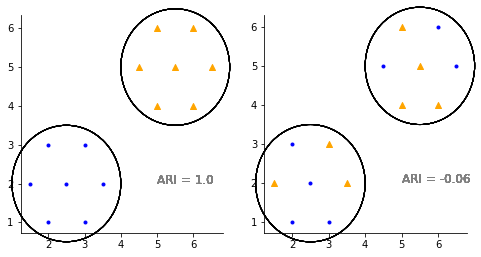

In [2]:
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sbn

true_labels = [1,1,1,1,1,1,1,0,0,0,0,0,0,0]

pred_labels_pure = [1,1,1,1,1,1,1,0,0,0,0,0,0,0]
pred_labels_random = [0,1,1,0,1,0,0,1,0,0,1,0,1,1]

pure = adjusted_rand_score(true_labels, pred_labels_pure)
random = adjusted_rand_score(true_labels, pred_labels_random)

X = [2,3,1.5,2.5,3.5,2,3,5,6,4.5,5.5,6.5,5,6]
Y = [3,3,2,2,2,1,1,6,6,5,5,5,4,4]

pure_markers = ['.']*7 + ['^']*7
random_markers = ['.' if x == 0 else '^' for x in pred_labels_random]

pure_colors = ['b' if m == '.' else 'orange' for m in pure_markers]
random_colors = ['b' if m == '.' else 'orange' for m in random_markers]

style = dict(size=12, color='gray')

fig, axes = plt.subplots(1,2, figsize = (8,4))

group_1 = plt.Circle((2.5, 2), 1.5, color='k', fill=False, clip_on = False)
group_2 = plt.Circle((X[10], Y[10]), 1.5, color='k', fill=False, clip_on = False)

for x,y,m,c in zip(X,Y,pure_markers,pure_colors):
    axes[0].scatter(x, y, marker = m, c = c)
    axes[0].add_artist(group_1)
    axes[0].add_artist(group_2)
    axes[0].text(5,2, f'ARI = {pure}', **style)
    
    #plt.title('Perfect clustering')

group_1 = plt.Circle((2.5, 2), 1.5, color='k', fill=False, clip_on = False, linestyle = '-')
group_2 = plt.Circle((X[10], Y[10]), 1.5, color='k', fill=False, clip_on = False)

for x,y,m,c in zip(X,Y,random_markers,random_colors):
    axes[1].scatter(x, y, marker = m, c = c)
    axes[1].add_artist(group_1)
    axes[1].add_artist(group_2)
    axes[1].text(5,2, f'ARI = {random.round(2)}', **style)
    
sbn.despine()

plt.savefig('ARI_example.png', dpi = 300)


# How was DESC built?
* Autoencoder was used to minimze transcriptome reconstruction loss
* The encoding layers were then used as the first layers of the DESC network
* Number of clusters and cluster centers are initialized by the Louvain’s clustering algorithm

![fig_1a](./Fig_1a_RESCALED.png)

# Validated on seven datasets

|Dataset|Sample count|Description|Reasoning|
|---|---|---|---|
|Genotype-Tissue Expression (GTEx) v7 |11,688|Samples from 30 human tissues|benchmark |
|Drosohpila | 10,286 | Midbrain of Drosohpila | N/A |
|Mouse retina | 23,494 | bipolar cells generated from retinas of six mice processed in two experimental batches | batch effect removal |
|Human kidney (2 datasets) | 15,693 | Kidney cells from four healthy human subjects and three with tumors | batch effect removal |
| Human PBMC | 24,679 | PBMCs from eight patients that were either unstimulated or stimulated with INF-$\beta$ | batch effect removal in presence of true biological variation |
| E18 Mouse brain cells | 1,306,127 | cortex, hippocampus and subventricular zone of two E18 C57BL/6 mice | Test scalablility |

# DESC can accurately cluster differeing cells on Drosophila dataset

![Fig_2b-c](./Fig_1b-c_TEST.png)

# DESC removes batch effect in mouse retina dataset

![Removes batch effect](./Fig_2a.png)

# Minimizes KL-divergence while maximizes API in retina dataset

![Minimizes KL-divergence while maximizes API](Fig_2b_and_c_horizontal.png)

# DESC can simultaniously cluster and remove batch effect on Kidney datasets

![Fig_3a/b](Fig_3a_and_b_RESCALED.png)

# DESC is able to seperate PBMC Dataset by cell type, but not by stimulation state

![Worrisome_fig](Fig_3c_horizontal.png)

# DESC performance

![Fig_3e](./Fig_3e_300_expand.png)

# Conclusions

* DESC has a comperable ARI to other top performing clustering methods while minimizing KL-divergence


* DESC minimzes the influence of bacth effects


* DESC trains faster and uses less memory than other clustering methods 

# Possible Pitfalls
* They have not compared DESC to the UMAP clustering algorithm, a scalable commonly used clustering algorithm 


* Aside from the CD14+ Monocytes, DESC doesn't seem to highly differentiate between stimulated and unstimulated cells